In [ ]:
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import torch
import torchvision as tv
import torchvision.transforms.functional as tvf
torch.set_grad_enabled(False)

import sys
sys.path.append('../')
from models.library import qres17m

In [2]:
device = torch.device('cuda:0')

# initialize model
lmb = 64
model = qres17m(lmb=lmb)
wpath = f'../checkpoints/qres17m/lmb{lmb}/last_ema.pt'
msd = torch.load(wpath)['model']
model.load_state_dict(msd)

model = model.to(device=device)
model.eval()
print(f'Using lmb={lmb}. Model weights={wpath}')

Using lmb=64. Model weights=../checkpoints/qres17m/lmb64/last_ema.pt


In [3]:
impath = Path('../images/celaba64-1.png')

im = tvf.to_tensor(Image.open(impath)).unsqueeze_(0).to(device=device)
nB, imC, imH, imW = im.shape

# mask out a small region
paint_box = (0.4,0.4, 0.8,0.8) # xyxy
x1, y1, x2, y2 = paint_box
h_slice = slice(round(y1*imH), round(y2*imH))
w_slice = slice(round(x1*imW), round(x2*imW))
im[:, :, h_slice, w_slice] = 0.5

inpaint_results = [im]
for i in tqdm(range(6)):
    im_sample = model.inpaint(im, paint_box, steps=20, temprature=0.8)
    inpaint_results.append(im_sample)
inpaint_results = torch.cat(inpaint_results, dim=0)
# svpath = f'runs/inpaint-{impath.stem}.png'
# tv.utils.save_image(to_save, fp=svpath, nrow=math.inf, padding=(imH//32), pad_value=1)

100%|██████████| 6/6 [00:05<00:00,  1.09it/s]


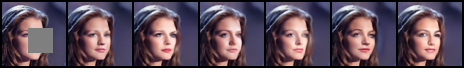

In [4]:
im = tv.utils.make_grid(inpaint_results, nrow=8)
tvf.to_pil_image(im)